# Clustering

In [43]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

# Clustering
from sklearn import cluster, preprocessing, metrics, mixture
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Visualization
from sklearn import manifold

Defining a few functions which will help us with clustering

In [3]:
# getting most frequent product label for each customer
def get_first_element(s):
    """In the case s is a pd.Series containing tuples of arrays, returns the first element of the first
    array."""
    
    return s.map(lambda x: x[0][0])

# Segmentation with Kmeans

In [38]:
data = pd.read_csv("./data/data.csv")
data.head()

,frequency,purchase_to_delivery_time,purchase_recency,mean_review_score,mean_comment_elapsed_time,mean_nb_installments,mean_nb_payment_types,mean_value_for_type,accessories,fashion_clothing,food_beverages,health_beauty_baby,home_garden_tools,toys_hobby,no_comment,comment,monetary_value
0000366f3b9a7992bf8c76cfdf3221e2,1,6.0,111,5.0,4.0,8.0,1.0,-0.461524,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,3.0,114,4.0,0.0,1.0,1.0,-0.366675,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,27.19
0000f46a3911fa3c0805444483337064,1,25.0,536,3.0,1.0,8.0,1.0,-0.531381,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,20.0,320,4.0,1.0,4.0,1.0,-0.530177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.62
0004aac84e0df4da2b147fca70cf8255,1,13.0,287,5.0,4.0,6.0,1.0,-0.310167,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,196.89


<AxesSubplot:>

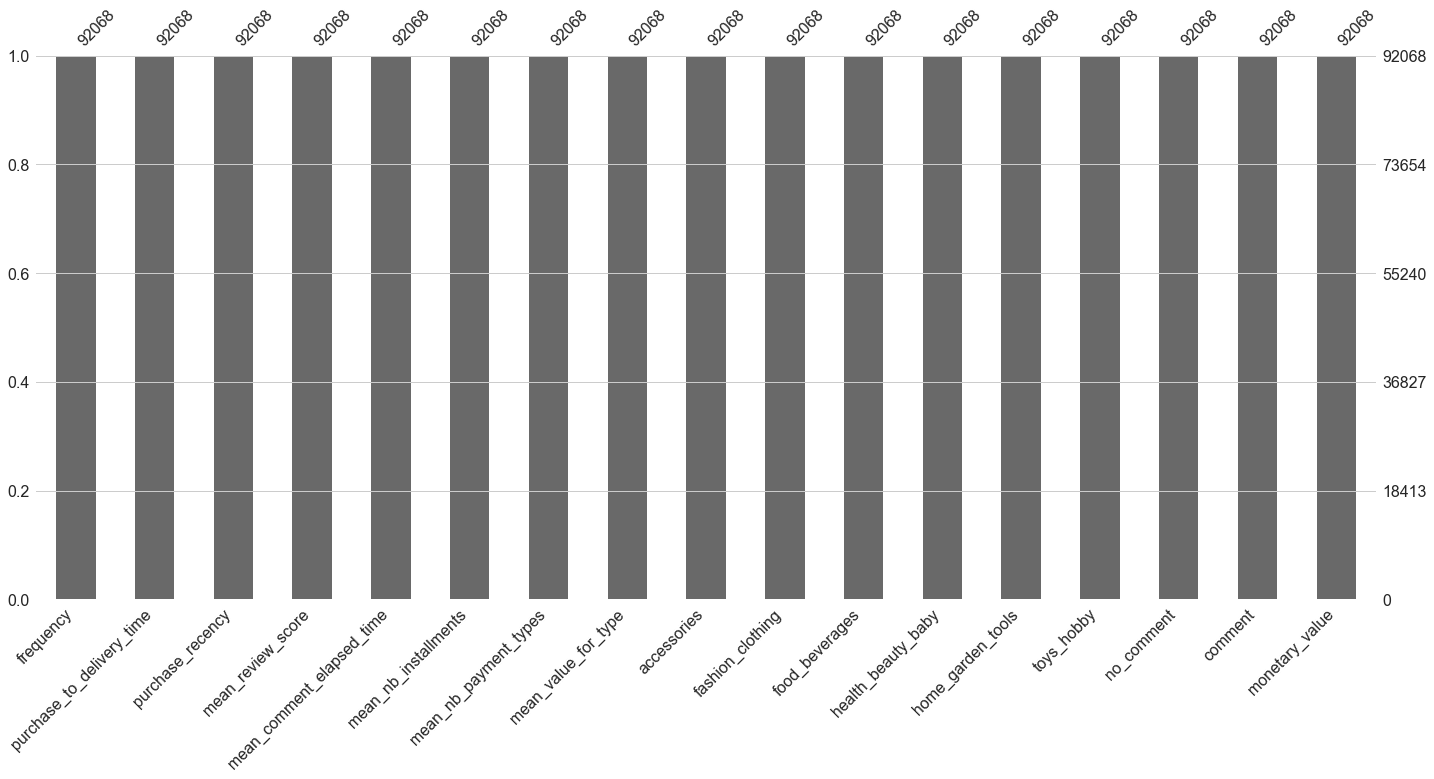

In [39]:
msno.bar(data)

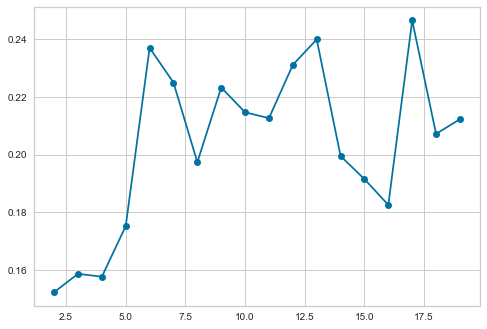

In [40]:
X = data.copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = pd.DataFrame(data=scaler.transform(X), columns=X.columns)

silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

# segmentation without the product_categories

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92068 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   frequency                  92068 non-null  int64  
 1   purchase_to_delivery_time  92068 non-null  float64
 2   purchase_recency           92068 non-null  int64  
 3   mean_review_score          92068 non-null  float64
 4   mean_comment_elapsed_time  92068 non-null  float64
 5   mean_nb_installments       92068 non-null  float64
 6   mean_nb_payment_types      92068 non-null  float64
 7   mean_value_for_type        92068 non-null  float64
 8   accessories                92068 non-null  float64
 9   fashion_clothing           92068 non-null  float64
 10  food_beverages             92068 non-null  float64
 11  health_beauty_baby         92068 non-null  float64
 12  home_garden_tools          92068 non-null  float6

In [51]:
cat_cols = data.columns[8:16]
num_cols = data.columns.drop(cat_cols)

X = data[num_cols]

# Standard scaling of numerical features except mean_value_for_type, which is already standardized
numeric_transformer = StandardScaler()  
preproc = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols.drop("mean_value_for_type"))],
                            remainder='passthrough'
                           )

X_std = pd.DataFrame(data=preproc.fit_transform(X), columns=X.columns)

ValueError: Shape of passed values is (92068, 8), indices imply (92068, 9)

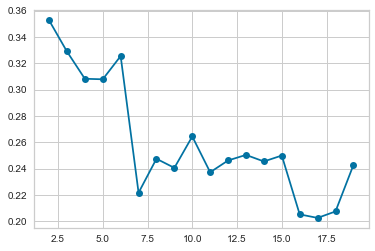

In [47]:
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

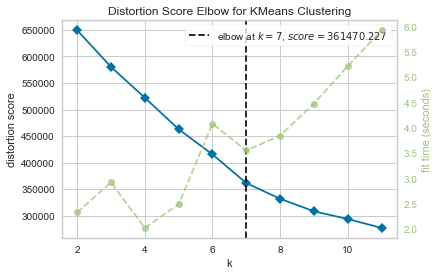

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

7 clusters seem to be optimal according to the elbow method. What about the shape of these clusters?

In [50]:
for n_clust in range(5, 10):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std, sample_size=1000)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

TypeError: fit() got an unexpected keyword argument 'sample_size'

Loading the datasets we will use in this section

In [96]:
products_items = pd.read_csv("./data/products_items.csv")

We merge the rfm data for each customer and the new product categories in order to perform a clustering of customers based on their rfm characteristics and the type of product they typically buy.

In [4]:
rfm_product = pd.read_csv("./data/rfm_product.csv")
rfm_product.head()

,customer_unique_id,order_id,purchase_recency,frequency,total_order_value,product_id,product_category_name_english,product_weight_g,price,product_volume,freight_to_total_price,product_label
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,160,1,142.0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1500.0,129.90,7616.0,0.084567,1
13,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,456,1,29.0,7ca5f56188492e30c50ba64de188aae7,bed_bath_table,200.0,13.90,4800.0,0.520690,1
15,00090324bbad0e9342388303bb71ba0a,85bf8863657bff31006811d45d1c8db9,207,1,64.0,f6fa93875f4a7dac03e0a22143f4d815,bed_bath_table,450.0,49.95,4275.0,0.215363,1
19,000c8bdb58a29e7115cfc257230fb21b,34801c59d6ec5c5e89bfefb6ebef314d,308,1,29.0,f07dfd51b27ae763526ca43745920b7d,bed_bath_table,175.0,13.90,1794.0,0.520690,1
21,000de6019bb59f34c099a907c151d855,c6d61340bd8baeedca7cc8e7f7ec07e9,425,1,257.0,9e572ff4654f7064419d97a891a8b0fc,bed_bath_table,1900.0,139.90,11515.0,0.110221,1


Let us now move on to clustering the customers based on RFM, and product_label

In [5]:
cluster_products_customers = rfm_product[["customer_unique_id",
                                          "purchase_recency", 
                                          "frequency", 
                                          "total_order_value",
                                          "product_label"]].copy()

# getting the most frequent product type (product label) for each customer, in order to characterize each
# customer according to the most frequently bought product type.

# first, we get rid of potential duplicates
cluster_products_customers.drop_duplicates(inplace=True)

# Then, most frequent product type for each customer
product_labels = (cluster_products_customers
                    .groupby("customer_unique_id")["product_label"]
                    .agg(stats.mode)
                    .apply(lambda x: x[0][0])
                    .reset_index()
          )

# 
cluster_products_customers = (pd.merge(cluster_products_customers.drop(columns="product_label"),
                                       product_labels,
                                       on="customer_unique_id"
                                      )
                             )

# Again, cleaning up from potential duplicates arising from the merge operation, and setting customer_unique_id
# as the index
cluster_products_customers.drop_duplicates(inplace=True)
cluster_products_customers.set_index("customer_unique_id", inplace=True)

# Finally, we one-hot encode the product_label column
clust_df = pd.concat((cluster_products_customers
                      .drop(columns=["product_label"]), 
                      pd.get_dummies(cluster_products_customers.product_label, prefix="label")),
                     axis=1)

In [6]:
clust_df.head()

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,0,1,0,0
0006fdc98a402fceb4eb0ee528f6a8d4,456,1,29.0,0,1,0,0
00090324bbad0e9342388303bb71ba0a,207,1,64.0,0,1,0,0
000c8bdb58a29e7115cfc257230fb21b,308,1,29.0,0,1,0,0
000de6019bb59f34c099a907c151d855,425,1,257.0,0,1,0,0


Finding out the optimal number of clusters
1. silhouette score

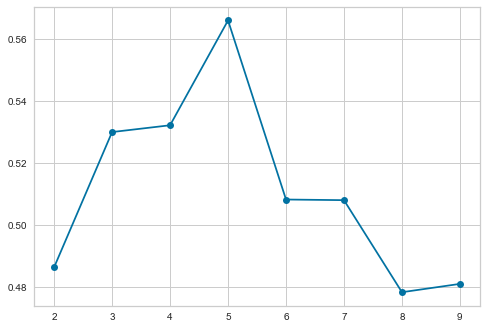

In [105]:
scaler = preprocessing.StandardScaler().fit(clust_df)
clust_df_std = pd.DataFrame(data=scaler.transform(clust_df), columns=clust_df.columns)

silhouettes = []

for num_clusters in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(clust_df_std)
    silh = metrics.silhouette_score(clust_df_std, cls.labels_, sample_size=1000)
    silhouettes.append(silh)

plt.plot(range(2, 10), silhouettes, marker='o')

2. Elbow method

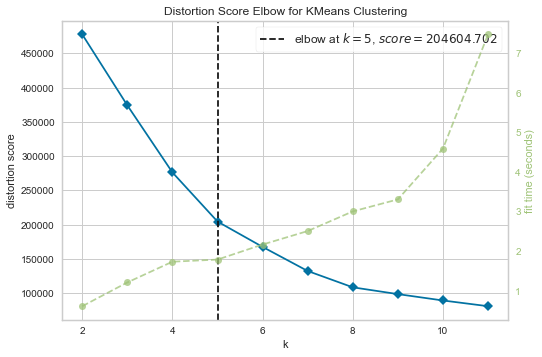

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [106]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(clust_df_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

Trying another clustering algorithm - the idea is to compare the silhouette scores with the previous method

Assessing the shape of the clusters

In [ ]:
for n_clust in range(3, 6):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(clust_df_std.sample(10000))    # Fit the data to the visualizer
    visualizer.poof()

Assessing the stability of clusters

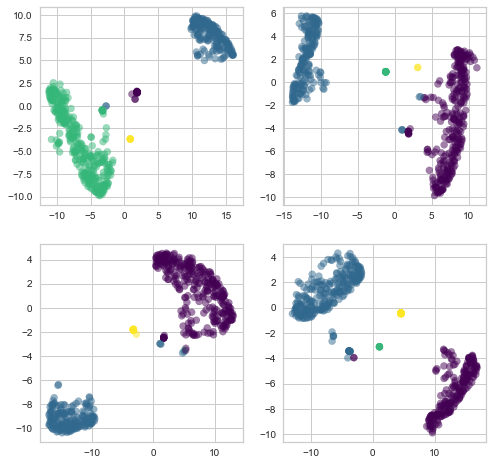

In [152]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=4).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.labels_
    
    # The coordinates (standardized) for each customer, and the associated category
    #categories_norm = pd.concat((clust_std, 
    #                         clust["product_category_name_english"]
    #                        ),
    #                        axis=1
    #                       )

    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=100, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

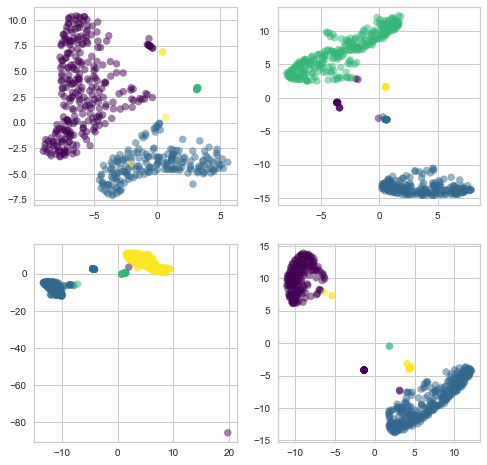

In [153]:
clust_std = clust_df_std.copy()
clust = clust_df.copy()

fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = mixture.GaussianMixture(n_components=4).fit(clust_std)
    
    # adding the labels obtained from clustering
    #clust["customer_label"] = clusters.labels_
    clust_std["customer_label"] = clusters.predict(clust_std)
    
    
    # Visualization
    XX = clust_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=100, n_iter=2000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [119]:
clusters = cluster.KMeans(n_clusters=6, n_init=10).fit(clust_df_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(scaler.inverse_transform(centroids).round(2), columns=clust_df.columns)
centroids

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3
0,434.17,1.00,152.47,-0.0,1.00,0.0,0.00
1,174.54,1.00,162.53,-0.0,1.00,0.0,0.00
2,264.75,1.03,873.28,1.0,0.00,0.0,0.00
3,279.90,1.00,151.76,-0.0,0.00,0.0,1.00
4,268.47,2.12,311.15,0.0,0.75,0.0,0.25
5,308.55,1.02,225.79,0.0,-0.00,1.0,-0.00


434 d. = approx 1 year 3 months\
174 d. = approx 6 months\
265 d., 268 d., 280 d. = approx 9 months\
308 d. = approx 10 months

New purchase <--> new customer: 
* low monetary value purchases (type 1) = main clients. They arrive regularly, from the beginning? It seems like they have been purchasing for a slightly higher value lately.

* Some buy more than once: but other than that, they bear the same characteristics as the legacy customers. (approx 150BRL/purchase, from cat. 1 and 3. 

* Cat. 3 seems to be linked with purchases made about 270-280 days ago (9 months). Did olist added new specific items to its catalogue at that time?

* Cat 0 definitely associated to high monetary value customers. They bought only once over the past 2 and a half years, about 9 months ago (a little less).

### results for the clustering of customers based on their rfm and the main categories of products purchased

**Personae:**

|Persona#|N samples|purchase_recency|frequency|total_order_value|category 1|category 2|category 3|category 4|
|---|---|---|---|---|---|---|---|---|
|0|3467|305|1.03|249|0|1|0|0|
|1|43758|291|1|159|0|0|1|0|
|2|43490|281|1|151|1|0|0|0|
|3|250|266|1|1169|0.004|0|0|0.996|
|4|2878|268|2.1|311|0.61|0.003|0.39|0|

# RFM and Geolocation

## Geolocation clustering

**Clustering by zip code, and geolocalisation**

In [7]:
prefix_clustering = pd.read_csv("./data/prefix_clustering.csv")
prefix_clustering.set_index("customer_zip_code_prefix").head()

,urban_coastal,zip_category
customer_zip_code_prefix,,
1003,1,0
1004,1,0
1005,1,0
1006,1,0
1007,1,0


First attempt with DBSCAN to take advantage of the higher density of population along the coast and in some inner regions

Counter({0: 7566, -1: 3859, 2: 866, 1: 756, 4: 667, 5: 605, 3: 485})


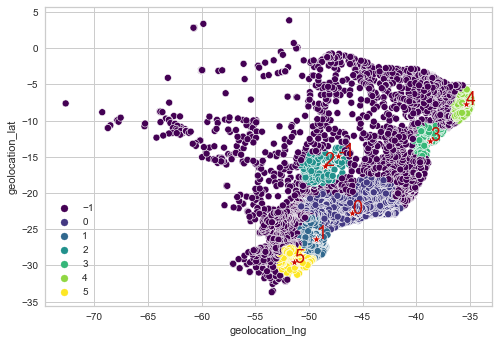

In [330]:
X = prefix_clustering[["geolocation_lat", "geolocation_lng"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

dbscan = cluster.DBSCAN(eps=0.2, min_samples=300).fit(X_std)
print(Counter(dbscan.labels_))


# adding the labels obtained from clustering
X["label"] = dbscan.labels_

centroids = pd.DataFrame(data=X.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X, x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

plt.show()

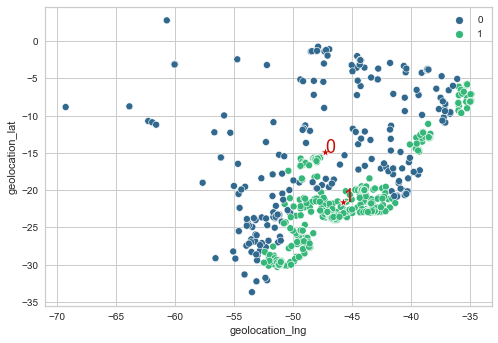

In [282]:
# adding the labels obtained from clustering
prefix_clustering["urban_coastal"] = dbscan.labels_
prefix_clustering.urban_coastal = prefix_clustering.urban_coastal.apply(lambda x: 0 if x==-1 else 1)

centroids = pd.DataFrame(data=prefix_clustering[["geolocation_lat", "geolocation_lng", "urban_coastal"]]
                         .groupby("urban_coastal").mean(), 
                         columns= ["geolocation_lat", "geolocation_lng", "urban_coastal"]
                        ) 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=prefix_clustering.sample(1000), 
                x="geolocation_lng", 
                y="geolocation_lat",
                hue="urban_coastal", 
                palette="viridis",
                ax=ax)
sns.scatterplot(data=centroids,
                x="geolocation_lng",
                y="geolocation_lat",
                marker="*", 
                s=100,
                color="r",
                ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i), fontsize=18, color="r")

plt.show()

Let us check that a city like Sao Paulo isn't made of mostly "noisy", i.e. non dense zip codes 

In [270]:
sao_paulo_zip = pd.read_csv("./data/sao_paulo_zip.csv")

sao_paulo = prefix_clustering.loc[pref_clust.customer_zip_code_prefix.isin(sao_paulo_zip.Sao_Paulo_zip)]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=sao_paulo.sample(100), x="geolocation_lng", y="geolocation_lat", hue="label", 
                palette="viridis", ax=ax1)
sns.scatterplot(data=sao_paulo, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax2)
plt.show()

,Sao_Paulo_zip
0,1151
1,4534
2,5704
3,5416
4,5713


**clustering by tov_avg and size**

Finding out the optimal number of clusters
1. Silhouette score

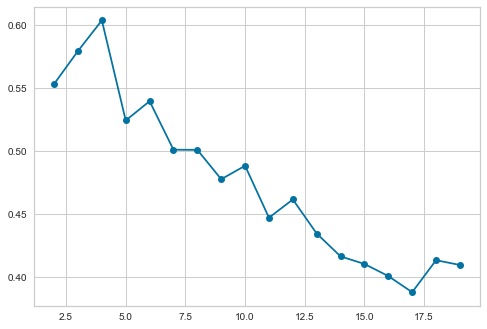

In [301]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

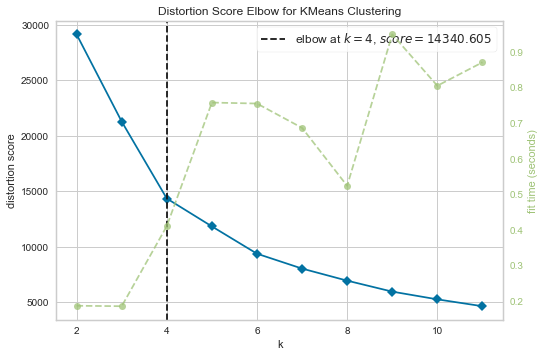

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [302]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

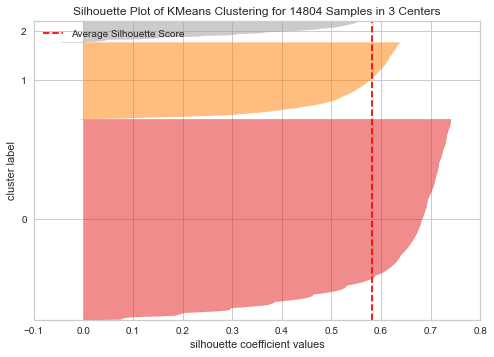

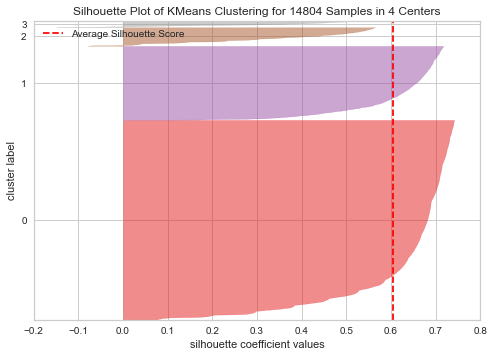

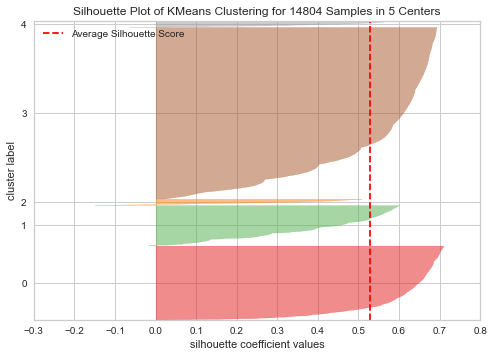

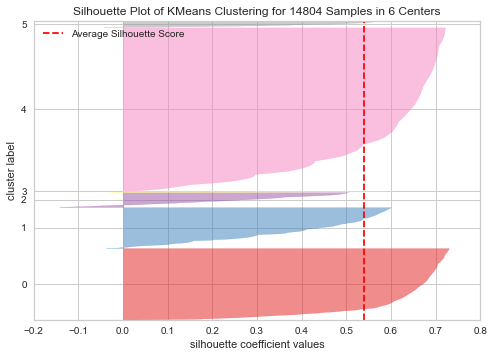

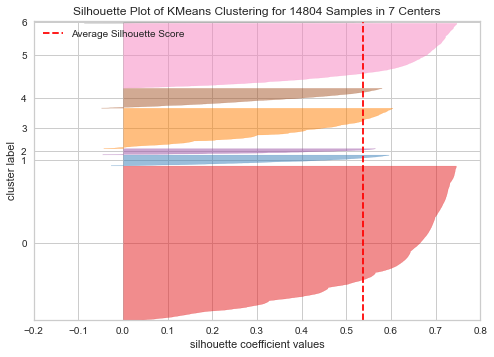

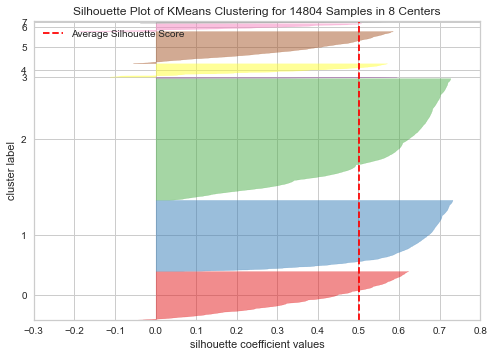

In [303]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

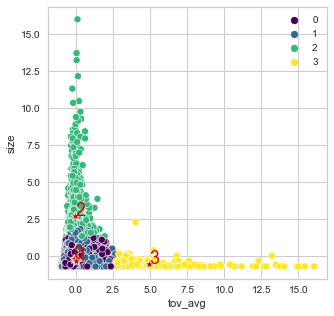

In [321]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

centroids = pd.DataFrame(data=clusters.cluster_centers_, 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X_std, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 0], centroids.to_numpy()[i, 1], str(i), fontsize=18, color="r")

In [322]:
real_centroids = pd.DataFrame(scaler.inverse_transform(centroids), columns=centroids.columns)
real_centroids["count"] = sorted(Counter(clusters.labels_).items())
real_centroids["count"] = real_centroids["count"].apply(lambda x: x[1])
real_centroids

,tov_avg,size,urban_coastal,count
0,142.668355,5.249363,1.000000e+00,9809
1,166.152265,4.165255,1.176836e-14,3661
2,157.341348,29.617391,9.207729e-01,1035
3,854.297604,2.354515,6.120401e-01,299


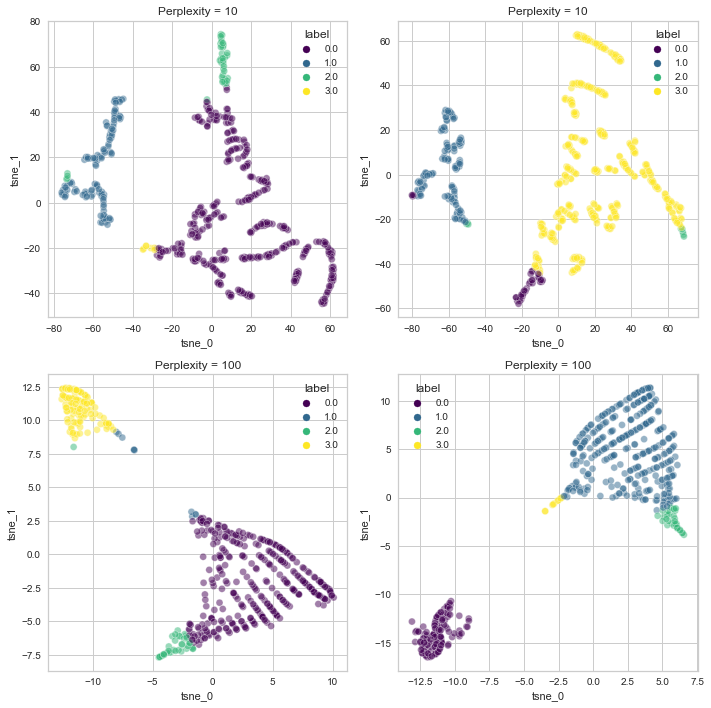

In [324]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    clusters = cluster.KMeans(n_clusters=4).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = clusters.labels_
    
    # Visualization
    XX = X_std.sample(500).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

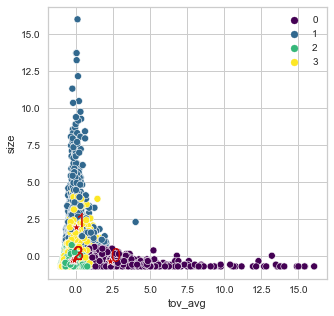

In [306]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

centroids = pd.DataFrame(data=X_std.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(data=X_std, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 0], centroids.to_numpy()[i, 1], str(i), fontsize=18, color="r")

In [320]:
real_centroids = pd.DataFrame(scaler.inverse_transform(centroids), columns=centroids.columns)
#real_centroids["urban_coastal"] = real_centroids["urban_coastal"].apply(lambda x: "urban/coastal" if x>0.5 else "rural/inland")
real_centroids["count"] = sorted(Counter(clusters.labels_).items())
real_centroids["count"] = real_centroids["count"].apply(lambda x: x[1])
real_centroids

,tov_avg,size,urban_coastal,count
0,488.553183,3.793755,6.006574e-01,1217
1,159.566609,23.419238,9.927405e-01,1653
2,126.997737,4.532136,1.000000e+00,8573
3,142.492170,4.735198,1.298961e-14,3361


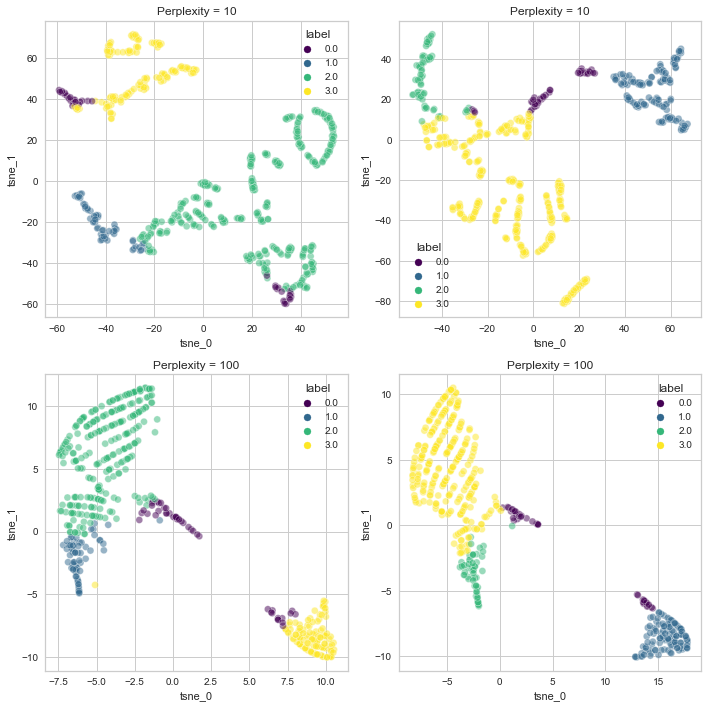

In [325]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = clusters.labels_
    
    # Visualization
    XX = X_std.sample(1000).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

A bit more balanced clusters than KMeans

In [326]:
X = prefix_clustering[["tov_avg", "size", "urban_coastal"]].copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
prefix_clustering["zip_category"] = clusters.labels_
prefix_clustering.to_csv("./data/prefix_clustering.csv", index_label=False)

In [169]:
city_clustering = pd.read_csv("./data/city_clustering.csv")
city_clustering.head()

,customer_city,geolocation_lat,geolocation_lng,tov_avg,size
0,abadia dos dourados,-18.474476,-47.407837,137.833333,3.0
1,abadiania,-16.193742,-48.709521,1025.520000,1.0
2,abaete,-19.158206,-45.446300,162.234167,12.0
3,abaetetuba,-1.723024,-48.881065,424.751818,11.0
4,abaiara,-7.358247,-39.045817,166.075000,2.0


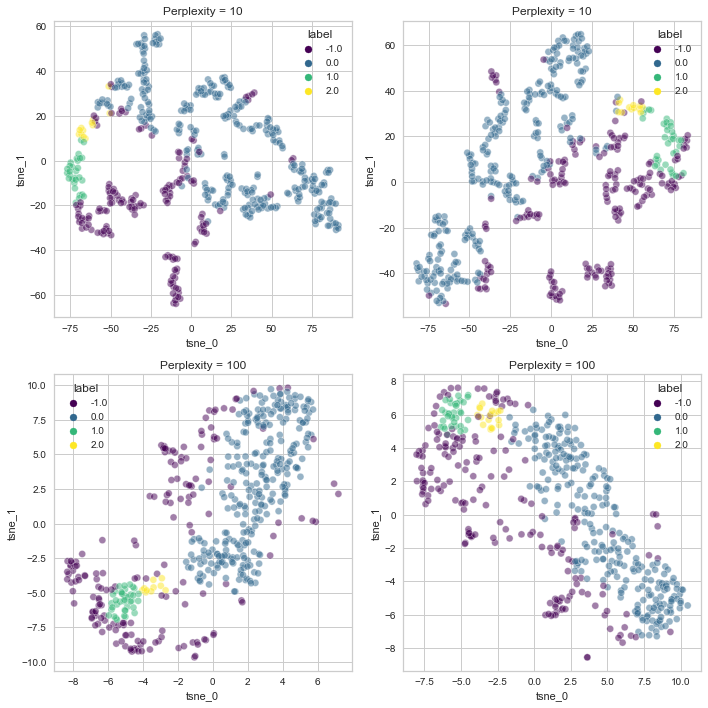

In [170]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))

for i, perp in zip(range(4), [10, 10, 100, 100]):
    X_std = X_std.sample(frac=1).reset_index(drop=True)
    dbscan = cluster.DBSCAN(eps=0.4, min_samples=75).fit(X_std)
    
    # adding the labels obtained from clustering
    X_std["label"] = dbscan.labels_
    
    # Visualization
    XX = X_std.sample(500).copy()
    X = XX.drop(columns="label")
    tsne = manifold.TSNE(n_components=2, perplexity=perp, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    X_tsne = pd.DataFrame(data=np.concatenate((X_tsne, np.array(XX.label, ndmin=2).T), axis=1),
                          columns=["tsne_0", "tsne_1", "label"])
    
    
    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X_tsne, x="tsne_0", y="tsne_1", hue="label", palette="viridis", alpha=0.5, ax=ax)
    ax.set_title(f"Perplexity = {perp}")
    
plt.tight_layout()
plt.show()

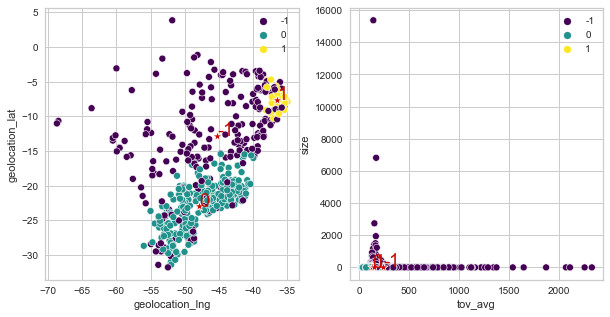

In [213]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

dbscan = cluster.DBSCAN(eps=0.4, min_samples=125).fit(X_std)
    
# adding the labels obtained from clustering
X["label"] = dbscan.labels_

centroids = pd.DataFrame(data=X.groupby("label").mean(), 
                         columns= X.columns
                        ) 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X, x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

Preparing the datasets

In [180]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

Finding out the optimal number of clusters
1. Silhouette score

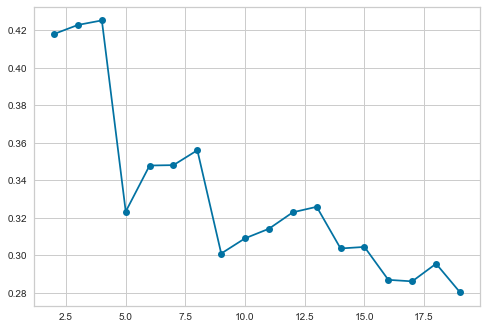

In [181]:
silhouettes = []

for num_clusters in range(2, 20):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_)
    silhouettes.append(silh)

plt.plot(range(2, 20), silhouettes, marker='o')

2. Elbow method

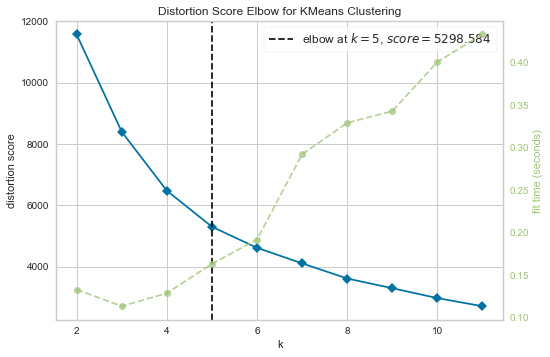

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [182]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

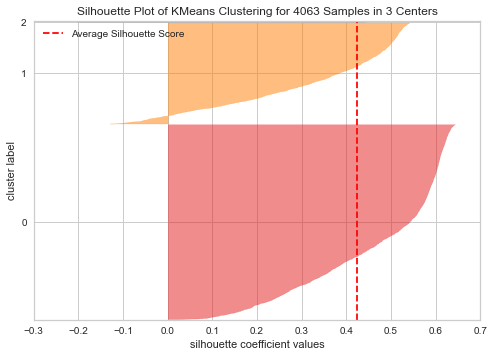

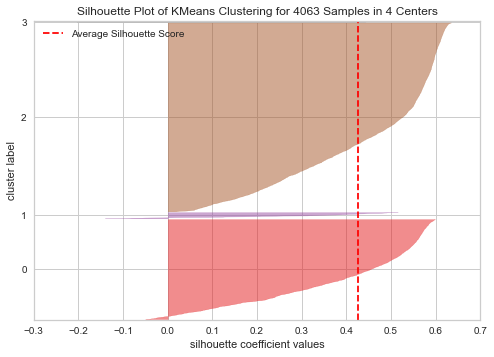

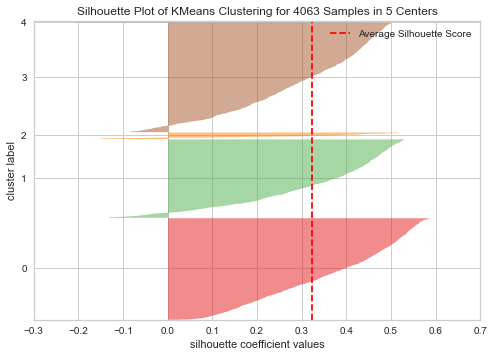

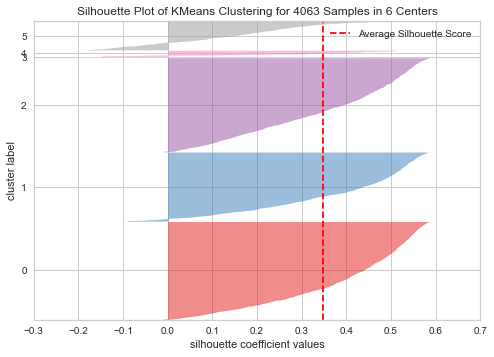

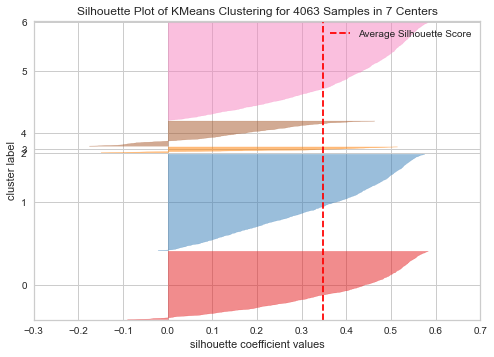

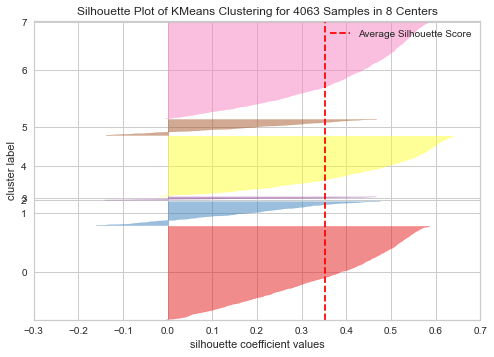

In [183]:
for n_clust in range(3, 9):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data

Assessing the stabilility of the clusters

In [193]:
clusters.cluster_centers_

array([[-5.78891830e-01, -5.15672673e-01, -1.88931445e-01,
        -2.91988238e-04,  3.00000000e+00],
       [ 1.06792941e+00,  9.64791900e-01,  5.03776618e-02,
        -5.23430616e-02,  1.00000000e+00],
       [-6.87814976e-01,  2.21722955e-01, -1.40526020e-01,
         3.98419678e+01,  2.00000000e+00],
       [ 4.23774795e-01,  1.42281111e-01,  4.90690949e+00,
        -8.02442485e-02,  0.00000000e+00]])

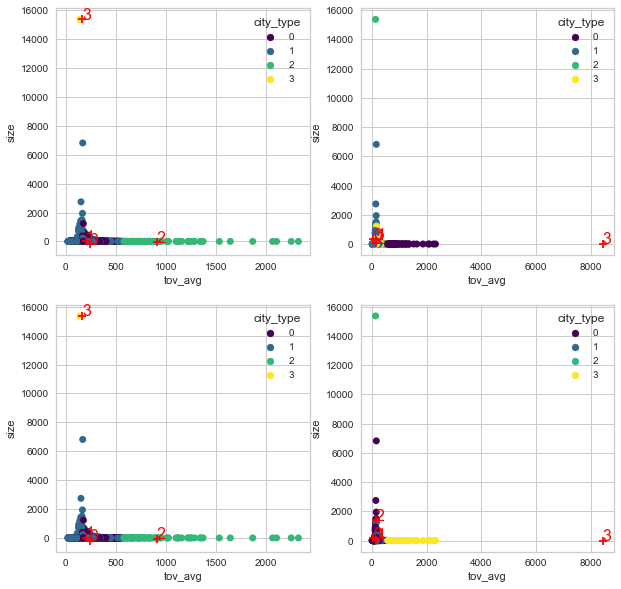

In [196]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    clusters = cluster.KMeans(n_clusters=4).fit(X_std)
    labels = clusters.labels_
    X["city_type"] = labels
    centers = scaler.inverse_transform(clusters.cluster_centers_.T)

    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X,
                    x="tov_avg",
                    y="size",
                    hue="city_type",
                    palette="viridis",
                    alpha=1,
                    linewidth=0,
                    ax=ax
                   )
    
    ax.scatter(centers[:, 2], centers[:, 3], s=50, c='red', marker="+")
    for i in range(len(np.unique(labels))):
        ax.text(centers[i, 2], centers[i, 3], i, fontsize=16, color='red')

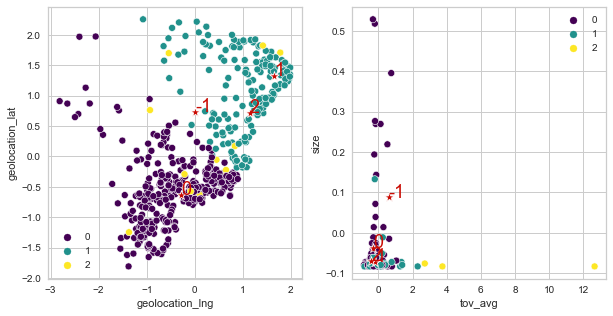

In [201]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.KMeans(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X_std.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X_std.sample(100), x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

for i in range(centroids.shape[0]):
    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

Trying another clustering algorithm (agglomerative clustering)

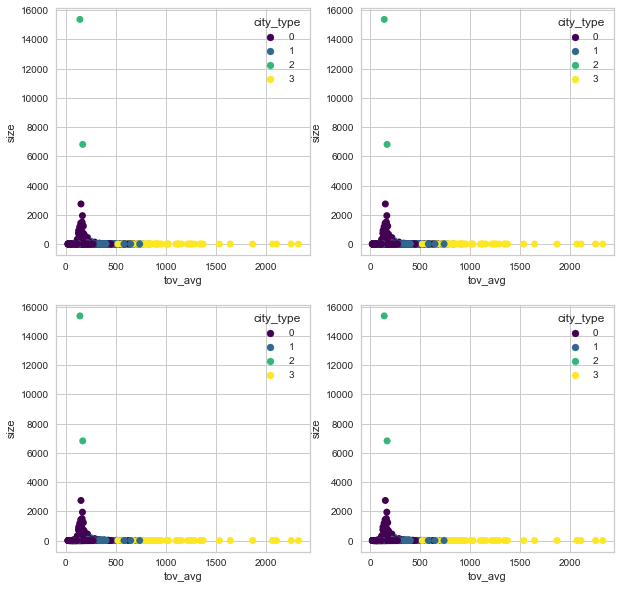

In [197]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

fig = plt.figure(figsize=(10, 10))
for i in range(4):
    clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
    labels = clusters.labels_
    X["city_type"] = labels
    #X_std = pd.DataFrame(cluster_cities_std, columns=["tov_avg", "size"])
    X_std["city_type"] = labels
    #centers = scaler.inverse_transform(clusters.cluster_centers_)


    ax = fig.add_subplot(2, 2, i+1)
    sns.scatterplot(data=X,
                    x="tov_avg",
                    y="size",
                    hue="city_type",
                    palette="viridis",
                    alpha=1,
                    linewidth=0,
                    ax=ax
                   )


    #ax.scatter(centers[:, 0], centers[:, 1], s=50, c='red', marker="+")
    #for i in range(len(np.unique(labels))):
    #    ax.text(centers[i, 0], centers[i, 1], i, fontsize=16, color='red')

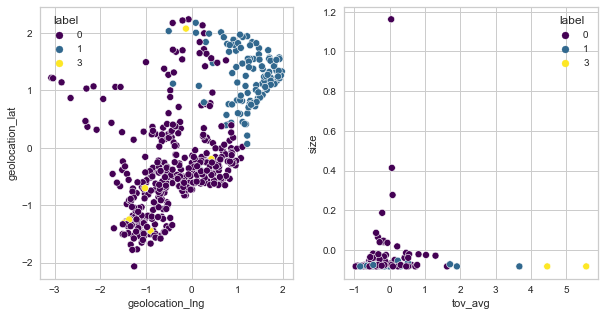

In [202]:
X = city_clustering.drop(columns=["customer_city"]).copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

# adding the labels obtained from clustering
clusters = cluster.AgglomerativeClustering(n_clusters=4).fit(X_std)
labels = clusters.labels_
X_std["label"] = clusters.labels_

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=X_std.sample(500), x="geolocation_lng", y="geolocation_lat", hue="label", palette="viridis", ax=ax)
#sns.scatterplot(data=centroids, x="geolocation_lng", y="geolocation_lat", marker="*", s=100, color="r", ax=ax)

#for i in range(centroids.shape[0]):
#    ax.text(centroids.to_numpy()[i, 1], centroids.to_numpy()[i, 0], str(i-1), fontsize=18, color="r")

ax = fig.add_subplot(1, 2, 2)
sns.scatterplot(data=X_std.sample(100), x="tov_avg", y="size", hue="label", palette="viridis", ax=ax)
#sns.scatterplot(data=centroids, x="tov_avg", y="size", marker="*", s=100, color="r", ax=ax)

#for i in range(centroids.shape[0]):
#    ax.text(centroids.to_numpy()[i, 2], centroids.to_numpy()[i, 3], str(i-1), fontsize=18, color="r")
plt.show()

AgglomerativeClustering gives the exact same result.

Clustering the neighborhoods with DBSCAN has an advantage: the closer neighborhoods are with each other, the higher the chance for them to be clustered in the same group. This means that with DBSCAN, we can almost "naturally" get the dense vs sparse areas. This is not the case if one clusters at the city level: a city like Sao Paulo might be too "far" from the next city and will be categorized as "noise", yet it is one if not the most densely populated region in Brazil, which means that the clustering will give wrong results here. Therefore we choose to continue with the DBSCAN clustering over the neighborhoods referenced by their zip codes.

# RFM and geolocation

Starting with rfm_customers, we merge with prefix_clustering on the "customer_zip_code_prefix" key

In [8]:
rfm_customers = pd.read_csv("./data/rfm_customers.csv")
rfm_customers.head()

,customer_unique_id,purchase_recency,frequency,total_order_value,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.0,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP
2,0000f46a3911fa3c0805444483337064,585,1,86.0,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,44.0,914991f0c02ef0843c0e7010c819d642,66812,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,336,1,197.0,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP


In [445]:
prefix_clustering = pd.read_csv("./data/prefix_clustering.csv", index_col="customer_zip_code_prefix")
prefix_clustering.head()

,urban_coastal,zip_category
customer_zip_code_prefix,,
1003,1,0
1004,1,0
1005,1,0
1006,1,0
1007,1,0


In [10]:
cols_to_keep = ["customer_unique_id","purchase_recency","frequency","total_order_value", 
                "customer_zip_code_prefix"]
rfm_geo = (pd.merge(rfm_customers[cols_to_keep], prefix_clustering, 
                    on="customer_zip_code_prefix", right_index=True)
           .drop(columns="customer_zip_code_prefix")
          )
rfm_geo.index = pd.Index(range(rfm_geo.shape[0]))
rfm_geo.head()

,customer_unique_id,purchase_recency,frequency,total_order_value,urban_coastal,zip_category
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,1,0
1,140349f48d58a4c5a30e66fe3da46797,308,1,160.0,1,0
2,6a527828dde2b20e0d5cda4e145deeee,281,1,21.0,1,0
3,a696ba5db33cf4835a04dd5965a86781,631,1,102.0,1,0
4,ab78e3dc0a9ba374d7cd4aaf92254371,560,1,61.0,1,0


In [11]:
# some customers have purchased from several zip codes/cities, and sometimes this results in the 
# customers being associated to two different zip categories. We choose to select only one zip category 
# randomly by removing all customer_unique_id duplicates 
rfm_geo = (rfm_geo
           .drop_duplicates(subset=["customer_unique_id"])
           .set_index("customer_unique_id")
          )
rfm_geo.head()

,purchase_recency,frequency,total_order_value,urban_coastal,zip_category
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,1,0
140349f48d58a4c5a30e66fe3da46797,308,1,160.0,1,0
6a527828dde2b20e0d5cda4e145deeee,281,1,21.0,1,0
a696ba5db33cf4835a04dd5965a86781,631,1,102.0,1,0
ab78e3dc0a9ba374d7cd4aaf92254371,560,1,61.0,1,0


In [448]:
X = rfm_geo.copy()
X = pd.concat((rfm_geo.drop(columns=["urban_coastal","zip_category"]), pd.get_dummies(rfm_geo.zip_category, prefix="zip")), axis=1)
X.head()

,purchase_recency,frequency,total_order_value,zip_0,zip_1,zip_2,zip_3
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,1,0,0,0
140349f48d58a4c5a30e66fe3da46797,308,1,160.0,1,0,0,0
6a527828dde2b20e0d5cda4e145deeee,281,1,21.0,1,0,0,0
a696ba5db33cf4835a04dd5965a86781,631,1,102.0,1,0,0,0
ab78e3dc0a9ba374d7cd4aaf92254371,560,1,61.0,1,0,0,0


Finding out the optimal number of clusters
1. Silhouette score

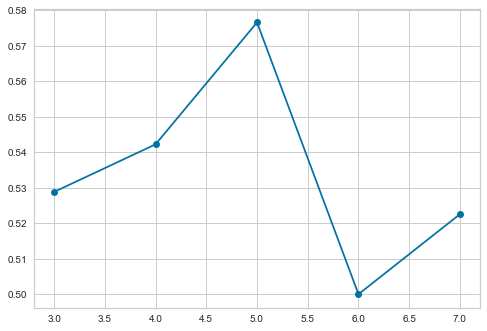

In [375]:
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)
silhouettes = []

for num_clusters in range(3, 8):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=10000)
    silhouettes.append(silh)

plt.plot(range(3, 8), silhouettes, marker='o')

2. Elbow method

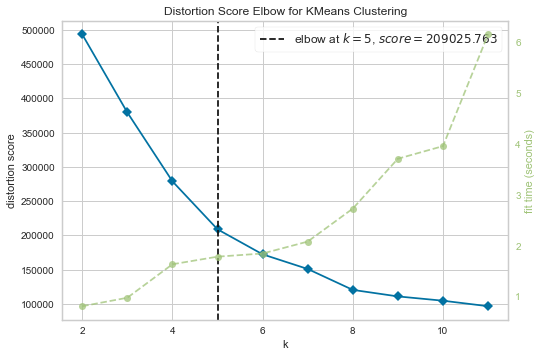

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [376]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

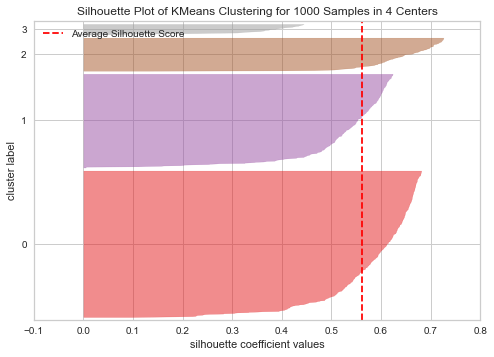

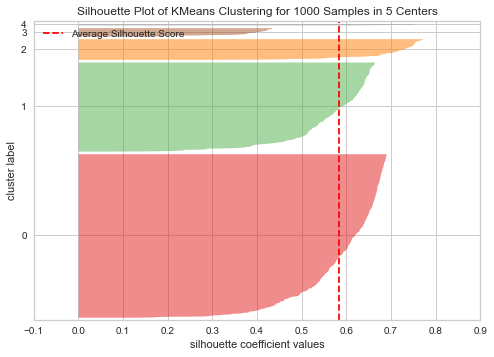

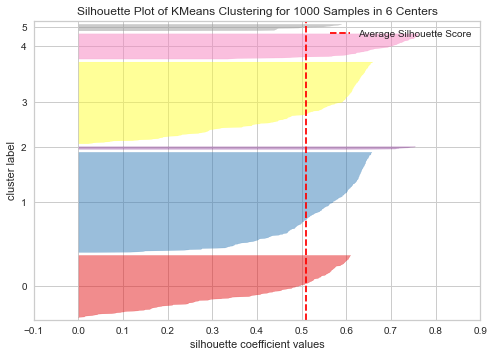

In [378]:
for n_clust in range(4, 7):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.show()    # Draw/show/poof the data

Assessing the stabilility of the clusters

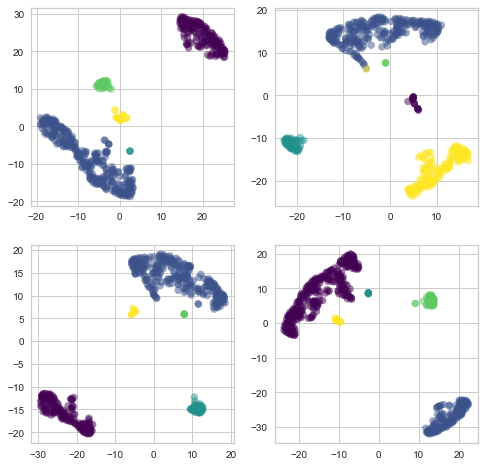

In [386]:
fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=5).fit(X_std)

    # adding the labels obtained from clustering
    X_std["customer_label"] = clusters.labels_

    # Visualization
    XX = X_std.sample(500).copy()
    X = XX.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000)
    X_tsne = tsne.fit_transform(X)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=XX["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [390]:
X = rfm_geo.copy()
X = pd.concat((rfm_geo.drop(columns="zip_category"), 
               pd.get_dummies(rfm_geo.zip_category, prefix="zip")),
              axis=1)

scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

clusters = cluster.KMeans(n_clusters=5, n_init=10).fit(X_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(data=scaler.inverse_transform(centroids).round(2), columns=X_std.columns)
centroids

,purchase_recency,frequency,total_order_value,zip_0,zip_1,zip_2,zip_3
0,287.03,1.00,158.57,0.00,0.00,1.00,-0.0
1,285.42,1.00,150.06,1.00,0.00,0.00,-0.0
2,302.71,1.00,191.87,-0.00,1.00,-0.00,0.0
3,267.73,2.12,305.70,0.53,0.08,0.39,0.0
4,289.19,1.02,805.38,0.00,-0.00,0.00,1.0


# RFM products and geolocation clustering

This time we start with clust_df which contains the product labels, and rfm_geo which contains the zip labels

In [9]:
# merging the two datasets
rfm_geo_products = pd.merge(clust_df, rfm_geo["zip_category"], on="customer_unique_id")

# one hot encoding of the zip_category variable
rfm_geo_products = pd.concat([rfm_geo_products.drop(columns="zip_category"),
                              pd.get_dummies(rfm_geo_products.zip_category, prefix="zip")
                             ], 
                             axis=1)
rfm_geo_products.head()

NameError: name 'rfm_geo' is not defined

1. KMeans

In [ ]:
X = rfm_geo_products.copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

silhouettes = []

for num_clusters in range(3, 15):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=10000)
    silhouettes.append(silh)

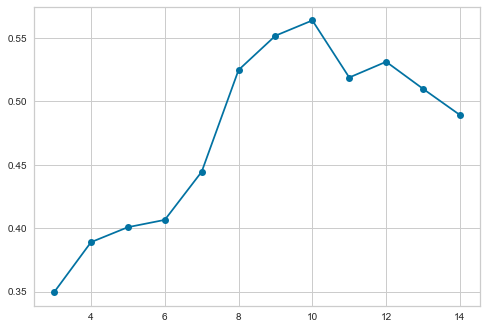

In [414]:
plt.plot(range(3, 15), silhouettes, marker='o')

2. Elbow method

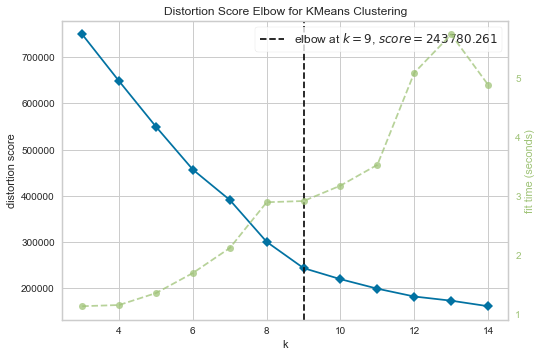

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [417]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

Assessing the shape of clusters

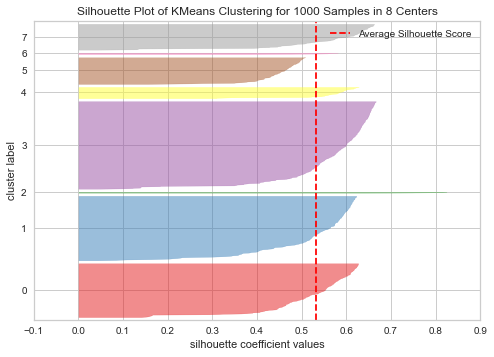

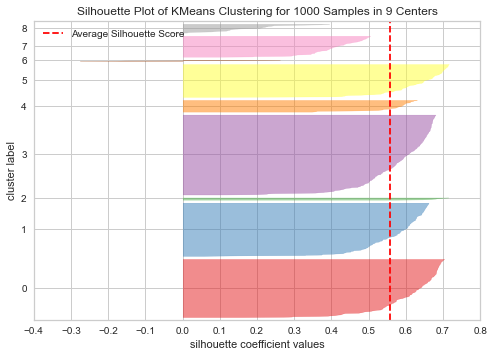

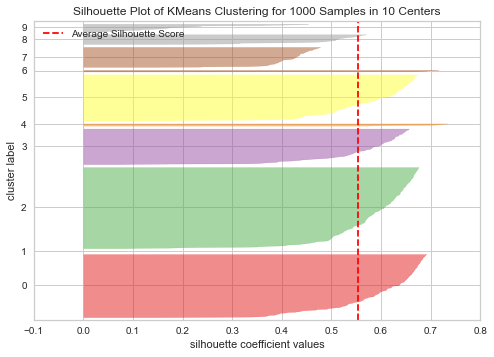

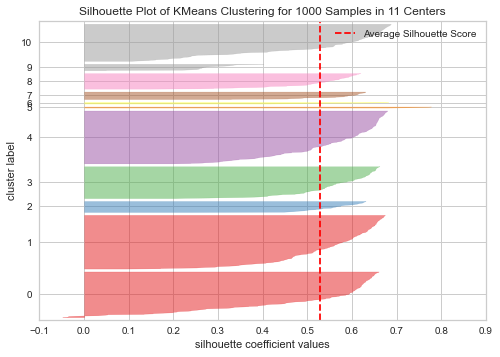

In [418]:
for n_clust in range(8, 12):
# Instantiate the clustering model and visualizer 
    model = cluster.KMeans(n_clusters=n_clust)
    visualizer = SilhouetteVisualizer(model)

    visualizer.fit(X_std.sample(1000))    # Fit the data to the visualizer
    visualizer.show()    # Draw/show/poof the data

Assessing the stabilility and quality of the clusters

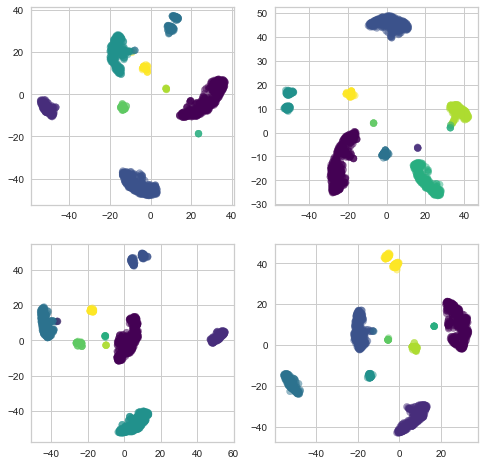

In [439]:
fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=9).fit(X_std)

    # adding the labels obtained from clustering
    X_std["customer_label"] = clusters.labels_

    # Visualization
    y = X_std.sample(1000).copy()
    y_viz = y.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=5000)
    y_tsne = tsne.fit_transform(y_viz)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [440]:
X = rfm_geo_products.copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

clusters = cluster.KMeans(n_clusters=9).fit(X_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(data=scaler.inverse_transform(centroids).round(2), columns=X_std.columns)
centroids

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3,zip_0,zip_1,zip_2,zip_3
0,268.10,2.12,303.34,-0.0,0.75,0.00,0.25,0.53,0.08,0.39,0.00
1,288.78,1.00,148.60,-0.0,1.00,0.00,0.00,1.00,0.00,-0.00,0.00
2,277.45,1.00,141.66,-0.0,-0.00,0.00,1.00,1.00,0.00,0.00,0.00
3,264.43,1.03,847.15,1.0,-0.00,-0.00,0.00,0.49,0.11,0.32,0.08
4,279.12,1.00,149.95,-0.0,-0.00,0.00,1.00,-0.00,-0.00,1.00,-0.00
5,289.22,1.00,155.01,-0.0,1.00,0.00,0.00,-0.00,0.00,1.00,0.00
6,301.01,1.00,184.36,-0.0,0.54,-0.00,0.46,0.00,1.00,0.00,-0.00
7,308.68,1.02,222.25,-0.0,-0.00,1.00,0.00,0.55,0.10,0.35,0.00
8,288.67,1.02,732.00,-0.0,0.54,0.03,0.43,0.00,0.00,0.00,1.00


To reduce the number of personae and make the segmentation more interpretable, we will only retain the urban vs rural characteristics from the geolocation.

In [12]:
# merging the two datasets
rfm_geo_products = pd.merge(clust_df, rfm_geo["urban_coastal"], on="customer_unique_id")

# one hot encoding of the zip_category variable
#rfm_geo_products = pd.concat([rfm_geo_products.drop(columns="urban_coastal"),
#                              pd.get_dummies(rfm_geo_products.urban_coastal, prefix="is_urban")
#                             ], 
#                             axis=1)
rfm_geo_products.head()

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3,urban_coastal
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,1,142.0,0,1,0,0,1
0006fdc98a402fceb4eb0ee528f6a8d4,456,1,29.0,0,1,0,0,1
00090324bbad0e9342388303bb71ba0a,207,1,64.0,0,1,0,0,1
000c8bdb58a29e7115cfc257230fb21b,308,1,29.0,0,1,0,0,1
000de6019bb59f34c099a907c151d855,425,1,257.0,0,1,0,0,1


In [13]:
X = rfm_geo_products.copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

silhouettes = []

for num_clusters in range(3, 15):
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10).fit(X_std)
    silh = metrics.silhouette_score(X_std, cls.labels_, sample_size=10000)
    silhouettes.append(silh)

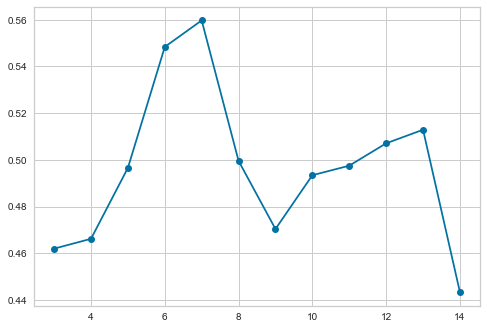

In [14]:
plt.plot(range(3, 15), silhouettes, marker='o')

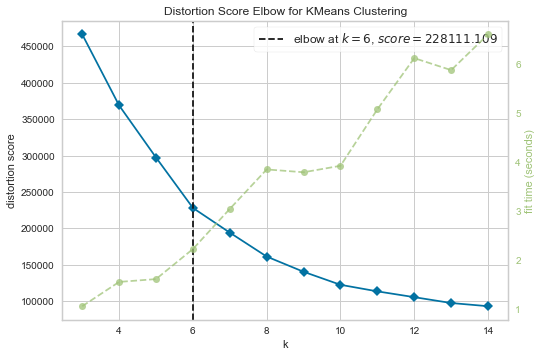

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof() 

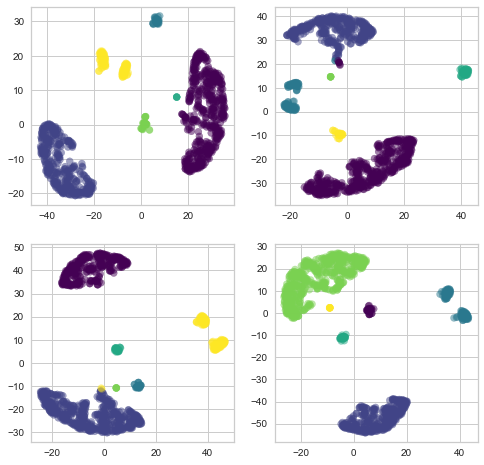

In [16]:
fig = plt.figure(figsize=(8, 8))

for i in range(4):
    
    clusters = cluster.KMeans(n_clusters=6).fit(X_std)

    # adding the labels obtained from clustering
    X_std["customer_label"] = clusters.labels_

    # Visualization
    y = X_std.sample(1000).copy()
    y_viz = y.drop(columns="customer_label")
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=5000)
    y_tsne = tsne.fit_transform(y_viz)
    
    ax = fig.add_subplot(2, 2, i+1)
    ax.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y["customer_label"], cmap="viridis", alpha=0.5)
plt.show()

In [18]:
X = rfm_geo_products.copy()
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)

clusters = cluster.KMeans(n_clusters=6).fit(X_std)
centroids = clusters.cluster_centers_

centroids = pd.DataFrame(data=scaler.inverse_transform(centroids).round(2), columns=X_std.columns)
centroids

,purchase_recency,frequency,total_order_value,label_0,label_1,label_2,label_3,urban_coastal
0,268.32,2.12,310.37,-0.0,0.75,0.0,0.25,0.91
1,288.97,1.00,153.17,-0.0,1.00,-0.0,0.00,1.00
2,277.88,1.00,148.06,-0.0,0.00,0.0,1.00,1.00
3,264.68,1.03,873.80,1.0,-0.00,-0.0,0.00,0.86
4,308.65,1.02,225.98,-0.0,-0.00,1.0,0.00,0.90
5,300.71,1.00,194.10,-0.0,0.54,-0.0,0.46,-0.00
